In [1]:
!nvidia-smi 

Tue Mar  8 08:48:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# example of training a gan on mnist

from numpy import expand_dims, zeros, ones, vstack 
from numpy.random import randn, randint
from tensorflow.keras import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot

In [3]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    
    model = Sequential()
    
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [4]:
# define the standalone generator model
def define_generator(latent_dim):
    
    model = Sequential()
    
    # foundation for 7x7 image
    n_nodes = 128*7*7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,128)))
    
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    
    return model

In [5]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt=Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [6]:
# load and prepare mnist training images
def load_real_samples():
    # load mnist dataset
    (trainX, _),(_,_) = mnist.load_data()
    # expand to 3d, e.g. add channels dimension
    X = expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X

In [7]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0,dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels
    y = ones((n_samples, 1))
    return X, y

In [8]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim*n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [9]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples,1))
    return X,y

In [10]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n*n):
        # define subplot
        pyplot.subplot(n,n,1+i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i,:,:,0], cmap='gray_r')
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

In [11]:
# plot generated images (reversed grayscale)
def plot_images(examples, n=10):
    # plot images
    for i in range(n*n):
        # define subplot
        pyplot.subplot(n,n,1+i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i,:,:,0], cmap='gray_r')
    pyplot.show()
    pyplot.close()

In [12]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(X_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

In [13]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch/2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch,1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            # print( f'Epoch {i+1}, batch {j}/{bat_per_epo}, dloss: {d_loss}, gloss: {g_loss}')
            # plot images, sometimes
            #if (j+1) % bat_per_epo == 0 or j % bat_per_epo == 0:
                # summarize loss on this batch
                #print( f'Epoch {i+1}, batch {j+1}/{bat_per_epo}, dloss: {d_loss}, gloss: {g_loss}')
        print(f'Epoch {i+1}, dloss: {d_loss}, gloss: {g_loss}')
        plot_images(X_fake)
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1, dloss: 0.6657981872558594, gloss: 1.061613917350769


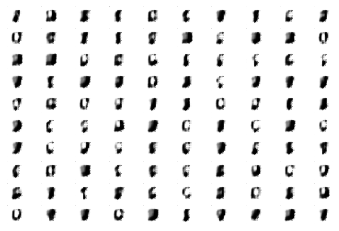

Epoch 2, dloss: 0.6997981667518616, gloss: 0.7292453050613403


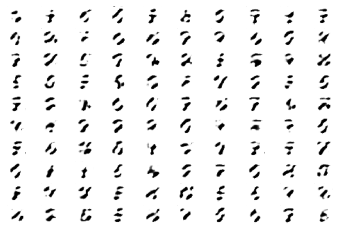

Epoch 3, dloss: 0.7052822709083557, gloss: 0.71348637342453


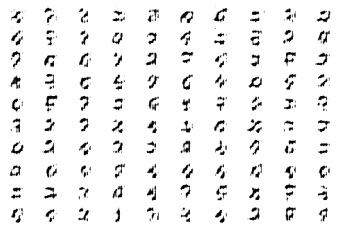

Epoch 4, dloss: 0.6902404427528381, gloss: 0.7085844874382019


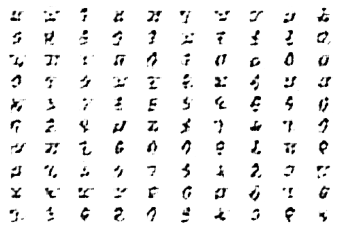

Epoch 5, dloss: 0.6291067600250244, gloss: 0.7782553434371948


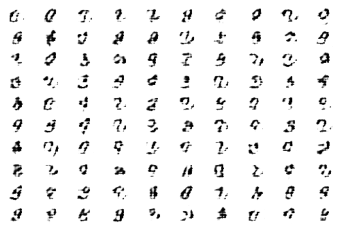

Epoch 6, dloss: 0.6916041970252991, gloss: 0.6858921647071838


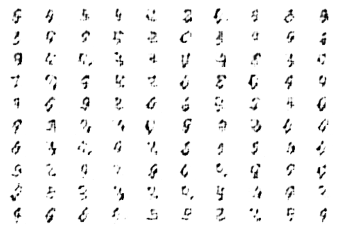

Epoch 7, dloss: 0.6712536215782166, gloss: 0.7077087163925171


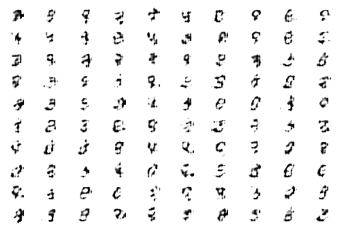

Epoch 8, dloss: 0.6870532631874084, gloss: 0.7266941666603088


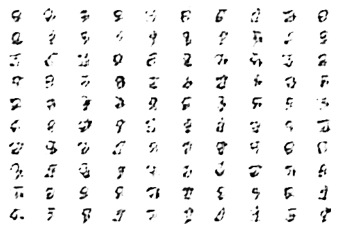

Epoch 9, dloss: 0.6801197528839111, gloss: 0.773991584777832


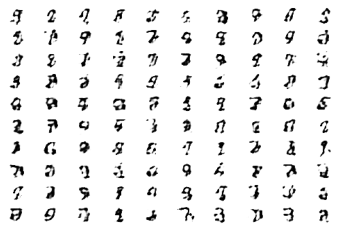

Epoch 10, dloss: 0.6834248304367065, gloss: 0.6985097527503967


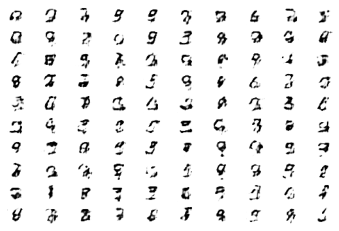

>Accuracy real: 92%, fake: 43%
Epoch 11, dloss: 0.6670951843261719, gloss: 0.710541307926178


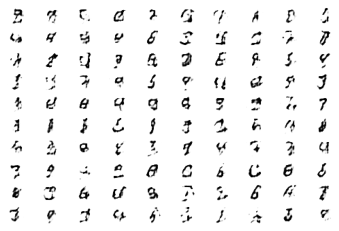

Epoch 12, dloss: 0.6747976541519165, gloss: 0.7459214925765991


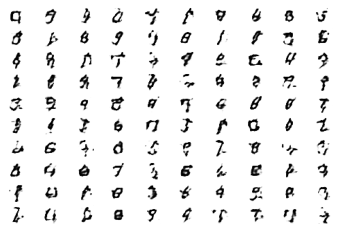

Epoch 13, dloss: 0.6761831641197205, gloss: 0.7019833326339722


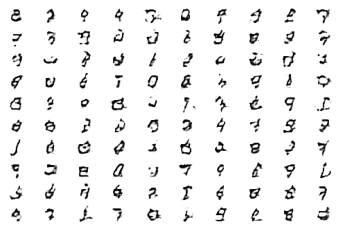

Epoch 14, dloss: 0.6800082325935364, gloss: 0.7314781546592712


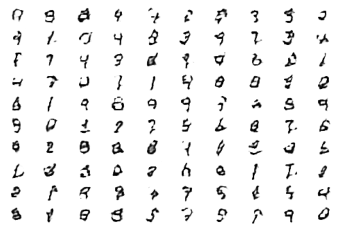

Epoch 15, dloss: 0.690686821937561, gloss: 0.7191884517669678


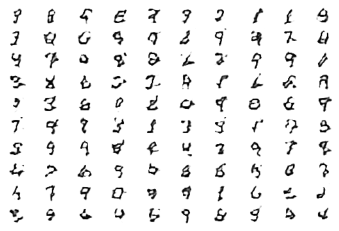

Epoch 16, dloss: 0.6840121150016785, gloss: 0.6935677528381348


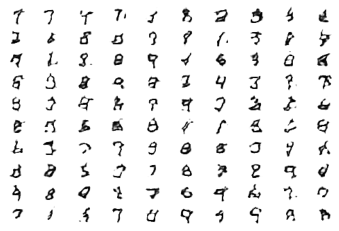

Epoch 17, dloss: 0.6825597286224365, gloss: 0.6746994853019714


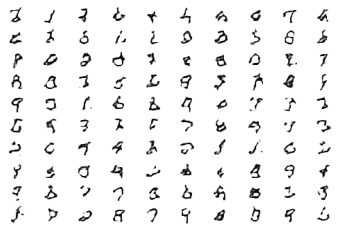

Epoch 18, dloss: 0.6757652759552002, gloss: 0.7186496257781982


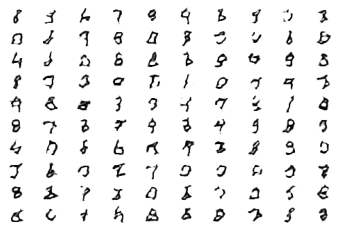

Epoch 19, dloss: 0.6988348364830017, gloss: 0.7474720478057861


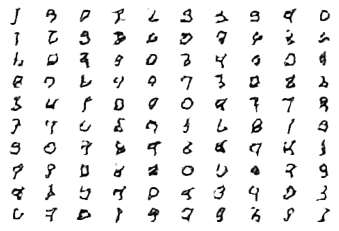

Epoch 20, dloss: 0.6831511855125427, gloss: 0.6917971968650818


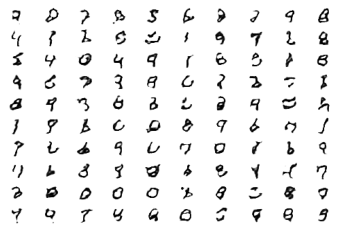

>Accuracy real: 85%, fake: 45%
Epoch 21, dloss: 0.6846529245376587, gloss: 0.7111486196517944


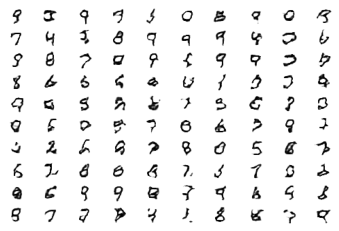

Epoch 22, dloss: 0.6858624219894409, gloss: 0.7281800508499146


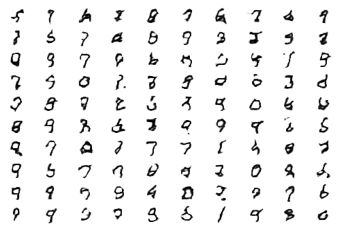

Epoch 23, dloss: 0.6891311407089233, gloss: 0.7223036289215088


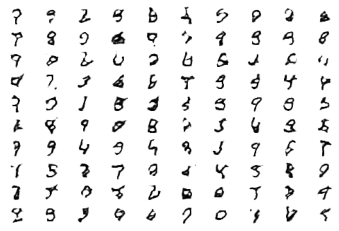

Epoch 24, dloss: 0.6818214058876038, gloss: 0.675234317779541


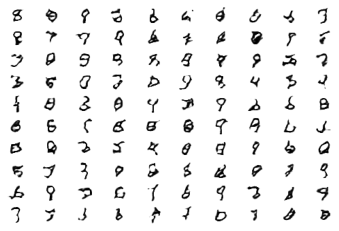

Epoch 25, dloss: 0.6941258907318115, gloss: 0.7103698253631592


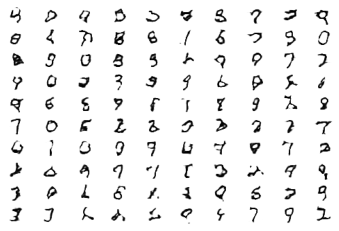

Epoch 26, dloss: 0.6802523136138916, gloss: 0.7099487781524658


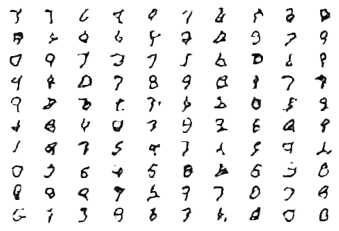

Epoch 27, dloss: 0.6823514103889465, gloss: 0.7341402173042297


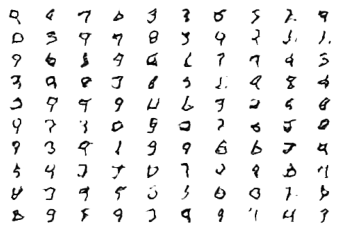

Epoch 28, dloss: 0.6823025345802307, gloss: 0.6649136543273926


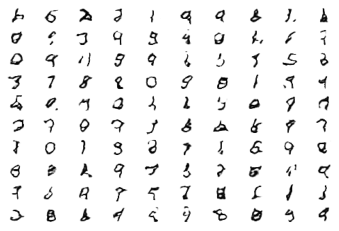

Epoch 29, dloss: 0.6776825189590454, gloss: 0.7695275545120239


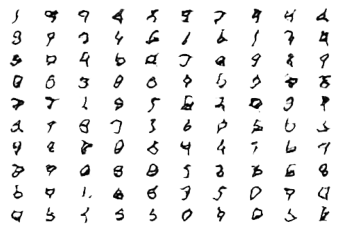

Epoch 30, dloss: 0.6996283531188965, gloss: 0.7303696274757385


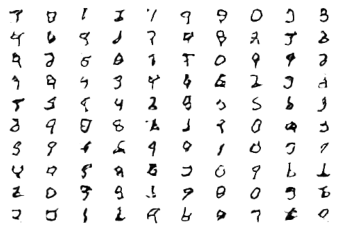

>Accuracy real: 56%, fake: 88%
Epoch 31, dloss: 0.6868880987167358, gloss: 0.793980062007904


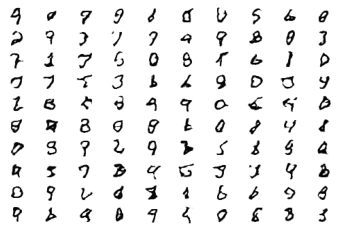

Epoch 32, dloss: 0.6783468127250671, gloss: 0.7735444903373718


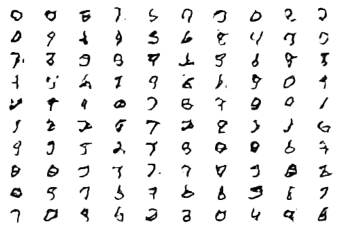

Epoch 33, dloss: 0.6827853918075562, gloss: 0.6992601156234741


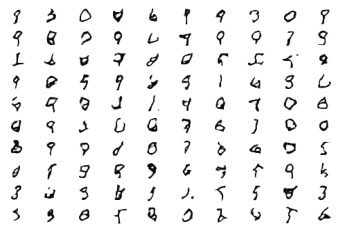

Epoch 34, dloss: 0.6904945969581604, gloss: 0.6828446388244629


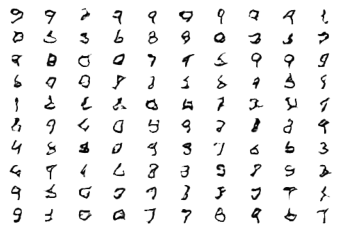

Epoch 35, dloss: 0.6882628798484802, gloss: 0.6833639740943909


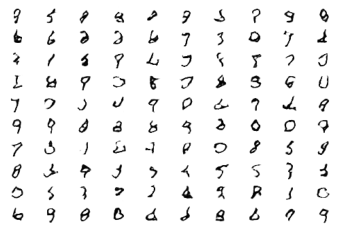

Epoch 36, dloss: 0.6943399310112, gloss: 0.6799429655075073


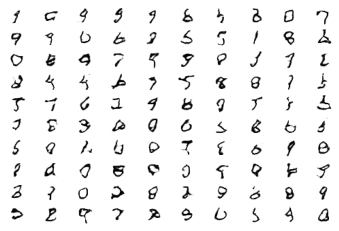

Epoch 37, dloss: 0.6816659569740295, gloss: 0.6863000988960266


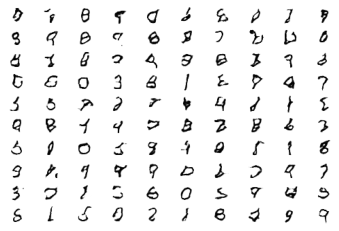

Epoch 38, dloss: 0.6889164447784424, gloss: 0.706670880317688


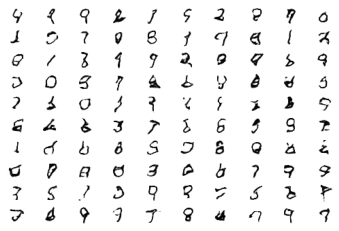

Epoch 39, dloss: 0.6815571784973145, gloss: 0.7002167701721191


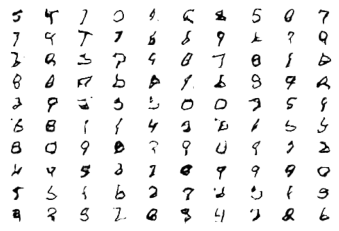

Epoch 40, dloss: 0.6817825436592102, gloss: 0.7224165201187134


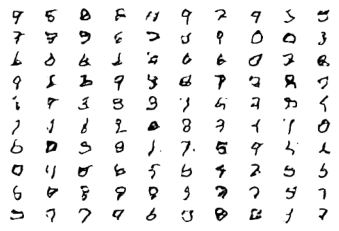

>Accuracy real: 56%, fake: 88%


KeyboardInterrupt: ignored

In [14]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)